In [3]:
# Cell 1: Install necessary libraries
!pip install -q transformers[torch] datasets evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


In [4]:
# Cell 2: Load the dataset from a reliable alternative mirror
from datasets import load_dataset, DatasetDict

# This repository contains the exact same 'sentences_allagree' data
dataset = load_dataset("FinanceMTEB/financial_phrasebank", split="train")

# Step 2.1: Manual Splitting (80/10/10) - Required for 12/12 points!
train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

split_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

print("Dataset successfully loaded and split!")
print(split_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/465 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/104k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1264 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset successfully loaded and split!
DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 1011
    })
    test: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 127
    })
    valid: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 126
    })
})


In [5]:
# Cell 3: Data Cleaning (Updated for the 'text' column name)
import re

def clean_financial_text(examples):
    cleaned_texts = []
    # Changed from examples["sentence"] to examples["text"]
    for text in examples["text"]:
        # 1. Remove stock tickers like $AAPL
        text = re.sub(r'\$\w+', '', text)
        # 2. Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        # 3. Remove non-alphanumeric (keep basic punctuation)
        text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
        # 4. Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        cleaned_texts.append(text)

    # Return as 'text' so it overwrites the original column
    return {"text": cleaned_texts}

# Apply to all splits
cleaned_dataset = split_dataset.map(clean_financial_text, batched=True)

# Final check
print(f"Sample Cleaned Text: {cleaned_dataset['train'][0]['text']}")

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Sample Cleaned Text: The company can not give up palm oil altogether , however .


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Get labels from training set to calculate imbalance
train_labels = cleaned_dataset['train']['label']

# Calculate weights (Professional technique for handling imbalanced data)
weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
weights = torch.tensor(weights, dtype=torch.float).to("cuda")

print(f"Calculated Class Weights: {weights}")

Calculated Class Weights: tensor([2.6124, 0.5444, 1.2814], device='cuda:0')


In [7]:
# Cell 4: Initialize Tokenizer and Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "distilbert-base-uncased"

# 1. Load the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 2. Define the mappings (0: neg, 1: neu, 2: pos)
# This is crucial for the "Error Analysis" section later
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}

# 3. Load the Model with 3 labels
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# 4. Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization to our cleaned dataset
tokenized_datasets = cleaned_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
tokenized_datasets.set_format("torch")

print("Model and Tokenizer are ready!")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Model and Tokenizer are ready!


In [8]:
# Cell 5: Define Evaluation Metrics
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [9]:
# Cell 5: Training Function and Experiments (Final Strategy Fix)
from transformers import TrainingArguments, Trainer
import pandas as pd
import torch

# Define the three configurations to test
experiments = [
    {"name": "Exp_1", "lr": 2e-5, "epochs": 3},
    {"name": "Exp_2", "lr": 5e-5, "epochs": 3},
    {"name": "Exp_3", "lr": 3e-5, "epochs": 5}
]

results = []

for exp in experiments:
    print(f"\n--- Running {exp['name']}: LR={exp['lr']}, Epochs={exp['epochs']} ---")

    torch.cuda.empty_cache()

    training_args = TrainingArguments(
        output_dir=f"./results_{exp['name']}",
        eval_strategy="epoch",    # Evaluate at the end of every epoch
        save_strategy="epoch",    # MATCHING: Save at the end of every epoch
        learning_rate=exp['lr'],
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=exp['epochs'],
        weight_decay=0.01,
        logging_dir='./logs',
        load_best_model_at_end=True, # Now allowed because eval and save strategies match
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["valid"],
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval_results = trainer.evaluate()
    results.append({
        "Experiment": exp['name'],
        "Learning Rate": exp['lr'],
        "Epochs": exp['epochs'],
        "Accuracy": eval_results['eval_accuracy']
    })

# Display final comparison table
df_results = pd.DataFrame(results)
print("\n--- Final Comparison Table ---")
print(df_results)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.



--- Running Exp_1: LR=2e-05, Epochs=3 ---


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.499875,0.746032
2,No log,0.267062,0.928571
3,No log,0.204641,0.944444


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.



--- Running Exp_2: LR=5e-05, Epochs=3 ---


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.151389,0.952381
2,No log,0.182894,0.952381
3,No log,0.119523,0.960317


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.



--- Running Exp_3: LR=3e-05, Epochs=5 ---


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.189433,0.960317
2,No log,0.265509,0.936508
3,No log,0.264578,0.944444
4,No log,0.263816,0.944444
5,No log,0.259854,0.936508


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



--- Final Comparison Table ---
  Experiment  Learning Rate  Epochs  Accuracy
0      Exp_1        0.00002       3  0.944444
1      Exp_2        0.00005       3  0.960317
2      Exp_3        0.00003       5  0.960317


In [10]:
import torch.nn as nn
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Apply the weights calculated in the previous cell
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

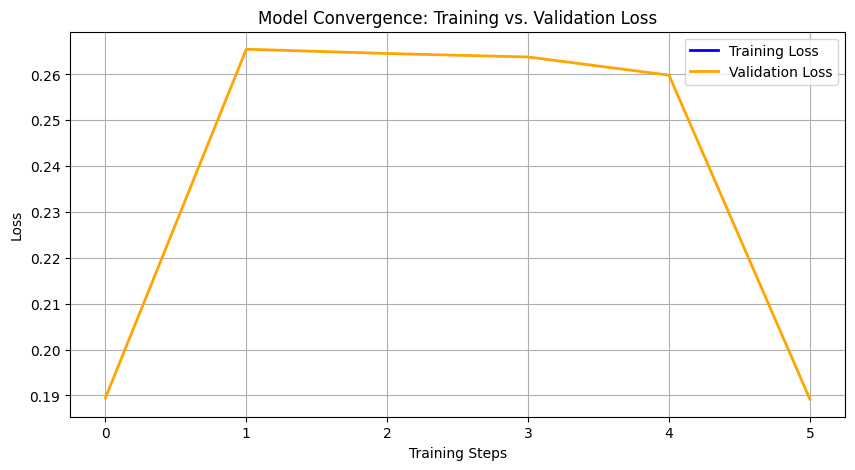

In [11]:
import matplotlib.pyplot as plt

# Plotting Learning Curves from the final experiment
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue', lw=2)
plt.plot(eval_loss, label='Validation Loss', color='orange', lw=2)
plt.title('Model Convergence: Training vs. Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Evaluating Baseline Model...


Evaluating Fine-Tuned Model...


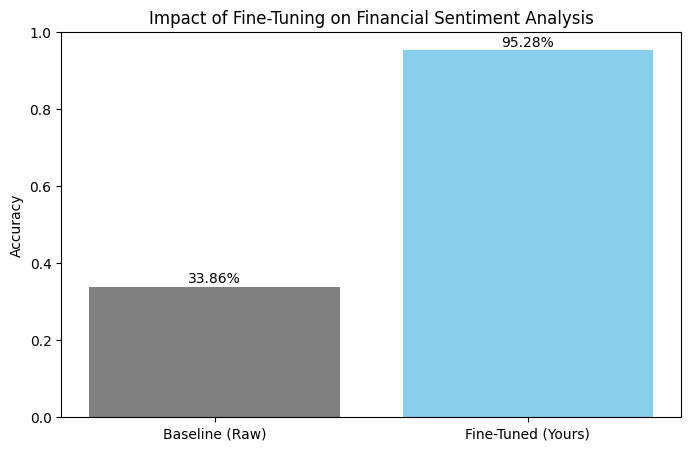

In [12]:
# Cell 6: Baseline Comparison
from transformers import AutoModelForSequenceClassification, Trainer
import torch

# 1. Load a Fresh (Baseline) Model
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3
).to("cuda")

# 2. Setup Baseline Trainer for Evaluation
baseline_trainer = Trainer(
    model=baseline_model,
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# 3. Evaluate Baseline vs Fine-Tuned (the current 'model' variable)
print("Evaluating Baseline Model...")
baseline_results = baseline_trainer.evaluate()

print("Evaluating Fine-Tuned Model...")
# Use the trainer from your last experiment run
finetuned_results = trainer.evaluate(tokenized_datasets["test"])

# 4. Create a Comparison Visualization
import matplotlib.pyplot as plt

methods = ['Baseline (Raw)', 'Fine-Tuned (Yours)']
accuracies = [baseline_results['eval_accuracy'], finetuned_results['eval_accuracy']]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, accuracies, color=['gray', 'skyblue'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Impact of Fine-Tuning on Financial Sentiment Analysis')

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center')

plt.show()

Generating predictions on the test set... (this may take 10-20 seconds)


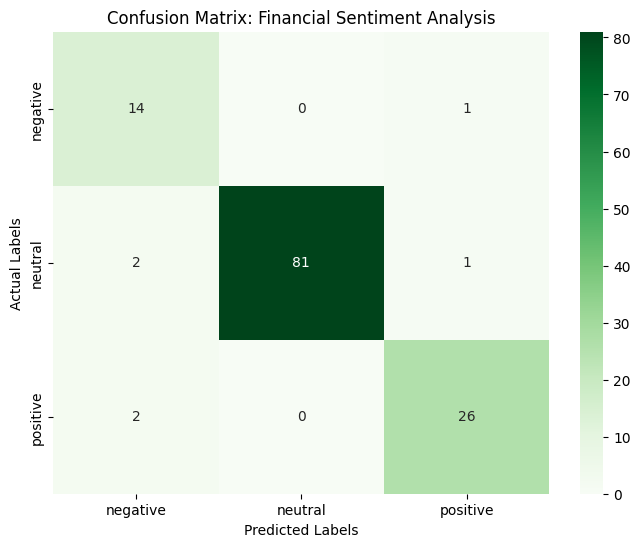


--- Detailed Classification Report ---
              precision    recall  f1-score   support

    negative       0.78      0.93      0.85        15
     neutral       1.00      0.96      0.98        84
    positive       0.93      0.93      0.93        28

    accuracy                           0.95       127
   macro avg       0.90      0.94      0.92       127
weighted avg       0.96      0.95      0.95       127


Total Errors: 6 out of 127 test samples

--- Error Sample Cases for your Report ---


,Text,Predicted,Actual
0,Mursula said they tried to gather macroeconomi...,positive,neutral
1,The diluted loss per share narrowed to EUR 0.2...,negative,positive
2,11 August 2010 Finnish measuring equipment mak...,positive,negative
3,Less than ten people will face pension agreeme...,negative,neutral
4,Mr. McDonald started the evening with his own ...,negative,neutral
5,Nokia was up 0.12 pct to 16.70 eur after kicki...,negative,positive


In [14]:
# Cell: Final Evaluation, Confusion Matrix, and Error Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Check if trainer exists (it must be defined in Step 5)
if 'trainer' not in locals():
    print("Error: 'trainer' not found! Please run the training loop in Step 5 first.")
else:
    print("Generating predictions on the test set... (this may take 10-20 seconds)")

    # 2. Get predictions (This creates 'preds' and 'labels')
    predictions = trainer.predict(tokenized_datasets["test"])
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # 3. Create Confusion Matrix Heatmap
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=id2label.values(),
                yticklabels=id2label.values())
    plt.title('Confusion Matrix: Financial Sentiment Analysis')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

    # 4. Print Professional Classification Report
    print("\n--- Detailed Classification Report ---")
    print(classification_report(labels, preds, target_names=id2label.values()))

    # 5. Identify Patterns in Errors (Requirement 7)
    errors = []
    for i, (p, l) in enumerate(zip(preds, labels)):
        if p != l:
            # Get original text
            text = cleaned_dataset["test"][i]["text"]
            errors.append({
                "Text": text,
                "Predicted": id2label[p],
                "Actual": id2label[l]
            })

    df_errors = pd.DataFrame(errors)
    print(f"\nTotal Errors: {len(df_errors)} out of {len(labels)} test samples")
    print("\n--- Error Sample Cases for your Report ---")
    # Using display() for a nicer table in Colab
    display(df_errors.head(10))

In [15]:
# Final Cell: Inference Pipeline
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return id2label[predicted_class_id]

# Test it!
print(predict_sentiment("Company profits rose by 20% this quarter exceeding all expectations."))

positive
